# Football Match Prediction Model
This project uses PyTorch to create neural network models that predict football match outcomes.

## Introduction
Football match prediction is a challenging task that combines statistical analysis with machine learning techniques. This notebook demonstrates how to build a binary classification model that predicts whether a home team will win a match (1) or not (0).

In [276]:
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import nn
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

df = pd.read_csv('data/normalized/normalized_matches_df.csv')

df.fillna(df.mean(), inplace=True)

## Data Preprocessing

### Turn data into tensors and create train, validation and test splits

In [277]:
# Feature selection
predictive_features = [
    'HT_Form', 'AT_Form',
    'HT_W_Odds', 'Draw_Odds', 'AT_W_Odds',
    '5GAV_FT_HT_Goals', '5GAV_FT_AT_Goals',
    '5GAV_HT_Shots', '5GAV_AT_Shots',
    '5GAV_HT_Shots_target', '5GAV_AT_Shots_target',
    '5GAV_HT_Corners', '5GAV_AT_Corners',
    'AVG_Influence_HT', 'AVG_ICT_Index_HT',
    'AVG_Influence_AT', 'AVG_ICT_Index_AT',
    'Injured_Players_HT', 'Injured_Players_AT',
    'HT_Players_Performances', 'AT_Players_Performances'
]

X = df[predictive_features]
y = df["FT_Result_code"] # Target variable: 1 if home team wins, 0 otherwise

# Convert to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)


print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

print(f"Feature dimensions: {X_train.shape[1]}")

Train: 2258, Val: 283, Test: 283
Feature dimensions: 21


## Model building
We'll check if GPU is available and define our target device:

In [278]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


### Simple Classification Model

First, we create a simple neural network with a single hidden layer:

In [279]:
class ClassificationModel(nn.Module):
    def __init__(self, input_features, hidden_units, output_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=output_features)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [280]:
# Initialize the model
input_features = X_train.shape[1]
hidden_units = 10  
output_features = 1 # Binary classification

simple_model = ClassificationModel(input_features, hidden_units, output_features).to(device)
print(simple_model)

ClassificationModel(
  (layer_1): Linear(in_features=21, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


### Testing the untrained model

In [281]:
X_test = X_test.to(device)
y_test = y_test.to(device)
untrained_preds = simple_model(X_test)

In [282]:
probabilities = torch.sigmoid(untrained_preds)

predictions = (probabilities > 0.5).float()

In [283]:
# Print results
print(f"Shape of predictions: {untrained_preds.shape}")
print(f"First 5 probabilities: {probabilities[:5].squeeze().tolist()}")
print(f"First 5 predictions: {predictions[:5].squeeze().tolist()}")
print(f"First 5 true labels: {y_test[:5].tolist()}")

Shape of predictions: torch.Size([283, 1])
First 5 probabilities: [0.5036428570747375, 0.5221861600875854, 0.5121790766716003, 0.49981820583343506, 0.4856905937194824]
First 5 predictions: [1.0, 1.0, 1.0, 0.0, 0.0]
First 5 true labels: [0.0, 1.0, 1.0, 0.0, 0.0]


As expected, the untrained model's predictions are close to random, showing no real predictive power yet.

### Improved model architecture
Now let's create a more sophisticated model with multiple layers and ReLU activations.

In [284]:
class SequentialFootballModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        
        self.network = nn.Sequential(
            # First block
            nn.Linear(input_features, 64),
            nn.ReLU(),
            
            # Second block
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # Third block
            nn.Linear(32, 16),
            nn.ReLU(),
            
            # Output layer
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.network(x)

## Model Training Utilities

In [285]:
# Calculate accuracy between true labels and predictions
def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct / len(y_pred)) * 100

In [286]:
def train_football_model(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, learning_rate=0.001):

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_val, y_val = X_val.to(device), y_val.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()

        y_logits = model(X_train)
        y_pred = torch.round(torch.sigmoid(y_logits.squeeze()))

        loss = loss_fn(y_logits.squeeze(), y_train)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = calculate_accuracy(y_train, y_pred)

        model.eval()
        with torch.inference_mode():
            val_logits = model(X_val)
            val_pred = torch.round(torch.sigmoid(val_logits.squeeze()))
            val_loss = loss_fn(val_logits.squeeze(), y_val)
            val_acc = calculate_accuracy(y_val, val_pred)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(acc)
        val_accuracies.append(val_acc)

        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Train acc: {acc:.2f}% | "
                  f"Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}%")

    # Final validation
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.round(torch.sigmoid(test_logits.squeeze()))
        test_loss = loss_fn(test_logits.squeeze(), y_test)
        test_acc = calculate_accuracy(y_test, test_pred)
    print(f"\nFinal test accuracy: {test_acc:.2f}%")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_acc
    }


## Model Training

In [287]:
seq_model = SequentialFootballModel(input_features).to(device)
results_improved_model = train_football_model(
    model=seq_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    epochs=100,
    learning_rate=0.001
)

Epoch: 0 | Loss: 0.69050, Train acc: 54.47% | Val loss: 0.68778, Val acc: 55.83%
Epoch: 10 | Loss: 0.68626, Train acc: 54.47% | Val loss: 0.68398, Val acc: 55.83%
Epoch: 20 | Loss: 0.68040, Train acc: 54.56% | Val loss: 0.67918, Val acc: 55.83%
Epoch: 30 | Loss: 0.66878, Train acc: 60.72% | Val loss: 0.66955, Val acc: 61.13%
Epoch: 40 | Loss: 0.65135, Train acc: 64.84% | Val loss: 0.65530, Val acc: 64.31%
Epoch: 50 | Loss: 0.63030, Train acc: 66.08% | Val loss: 0.63954, Val acc: 63.25%
Epoch: 60 | Loss: 0.61087, Train acc: 66.16% | Val loss: 0.62812, Val acc: 62.90%
Epoch: 70 | Loss: 0.59970, Train acc: 66.74% | Val loss: 0.62414, Val acc: 64.31%
Epoch: 80 | Loss: 0.59130, Train acc: 67.36% | Val loss: 0.61862, Val acc: 63.96%
Epoch: 90 | Loss: 0.58380, Train acc: 68.02% | Val loss: 0.61104, Val acc: 66.43%
Epoch: 99 | Loss: 0.57763, Train acc: 68.60% | Val loss: 0.60590, Val acc: 66.43%

Final test accuracy: 68.55%


In [288]:
print(f"\nFinal accuracy: {results_improved_model['test_accuracy']:.2f}%")


Final accuracy: 68.55%


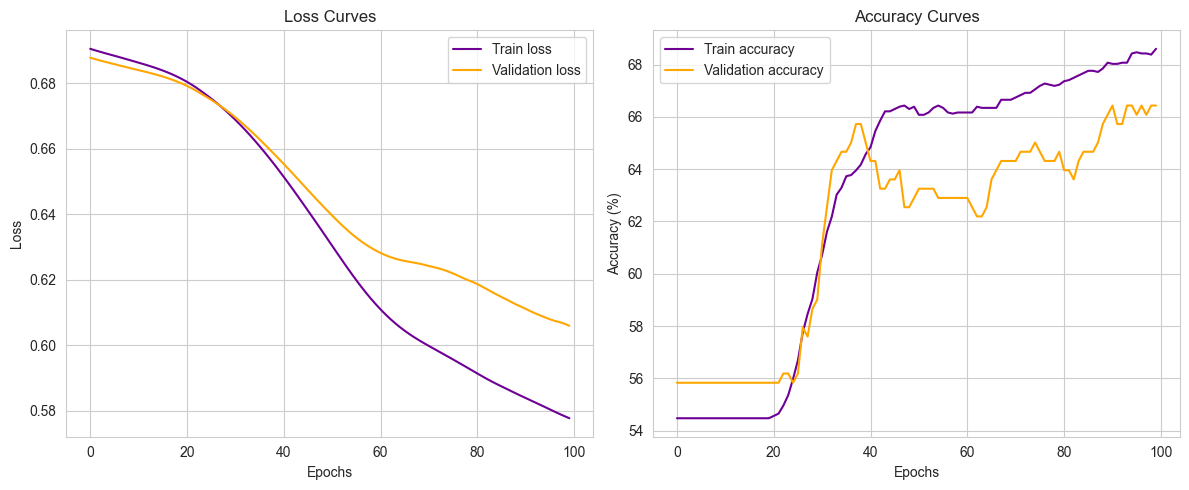

In [289]:
train_losses = results_improved_model['train_losses']
val_losses = results_improved_model['val_losses']
train_accuracies = results_improved_model['train_accuracies']
val_accuracies = results_improved_model['val_accuracies']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train loss", color="#6E0096")
plt.plot(val_losses, label="Validation loss", color="#FFA600")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train accuracy", color="#6E0096")
plt.plot(val_accuracies, label="Validation accuracy", color="#FFA600")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


## Model Improvements
In this section i tried to improve the model by:
- Deeper network architecture (input → 128 → 64 → 32 → 1)
- Added dropout layers (0.3, 0.2) for regularization
- Xavier initialization for weights
- Gradient clipping to prevent exploding gradients

In [290]:
class RegularizedFootballModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        
        self.network = nn.Sequential(
            # First block
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Second block
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third block
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # Output layer
            nn.Linear(32, 1)
        )
        
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.network(x)

In [291]:
input_features = X_train.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegularizedFootballModel(input_features).to(device)
print(model)

RegularizedFootballModel(
  (network): Sequential(
    (0): Linear(in_features=21, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [292]:
# Train with improved parameters
results = train_football_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    epochs=100,
    learning_rate=0.001
)

Epoch: 0 | Loss: 0.69417, Train acc: 50.71% | Val loss: 0.68508, Val acc: 56.18%
Epoch: 10 | Loss: 0.66656, Train acc: 60.50% | Val loss: 0.66344, Val acc: 64.31%
Epoch: 20 | Loss: 0.64033, Train acc: 64.84% | Val loss: 0.63776, Val acc: 62.90%
Epoch: 30 | Loss: 0.61713, Train acc: 65.46% | Val loss: 0.62325, Val acc: 64.31%
Epoch: 40 | Loss: 0.61031, Train acc: 65.37% | Val loss: 0.61885, Val acc: 66.78%
Epoch: 50 | Loss: 0.59672, Train acc: 67.27% | Val loss: 0.60883, Val acc: 67.14%
Epoch: 60 | Loss: 0.58969, Train acc: 66.74% | Val loss: 0.60555, Val acc: 67.49%
Epoch: 70 | Loss: 0.58421, Train acc: 68.91% | Val loss: 0.60039, Val acc: 69.26%
Epoch: 80 | Loss: 0.57504, Train acc: 69.44% | Val loss: 0.59809, Val acc: 69.26%
Epoch: 90 | Loss: 0.57508, Train acc: 70.24% | Val loss: 0.59720, Val acc: 69.26%
Epoch: 99 | Loss: 0.57331, Train acc: 68.47% | Val loss: 0.59688, Val acc: 67.49%

Final test accuracy: 69.26%


In [293]:
print(f"\nFinal accuracy: {results['test_accuracy']:.2f}%")


Final accuracy: 69.26%


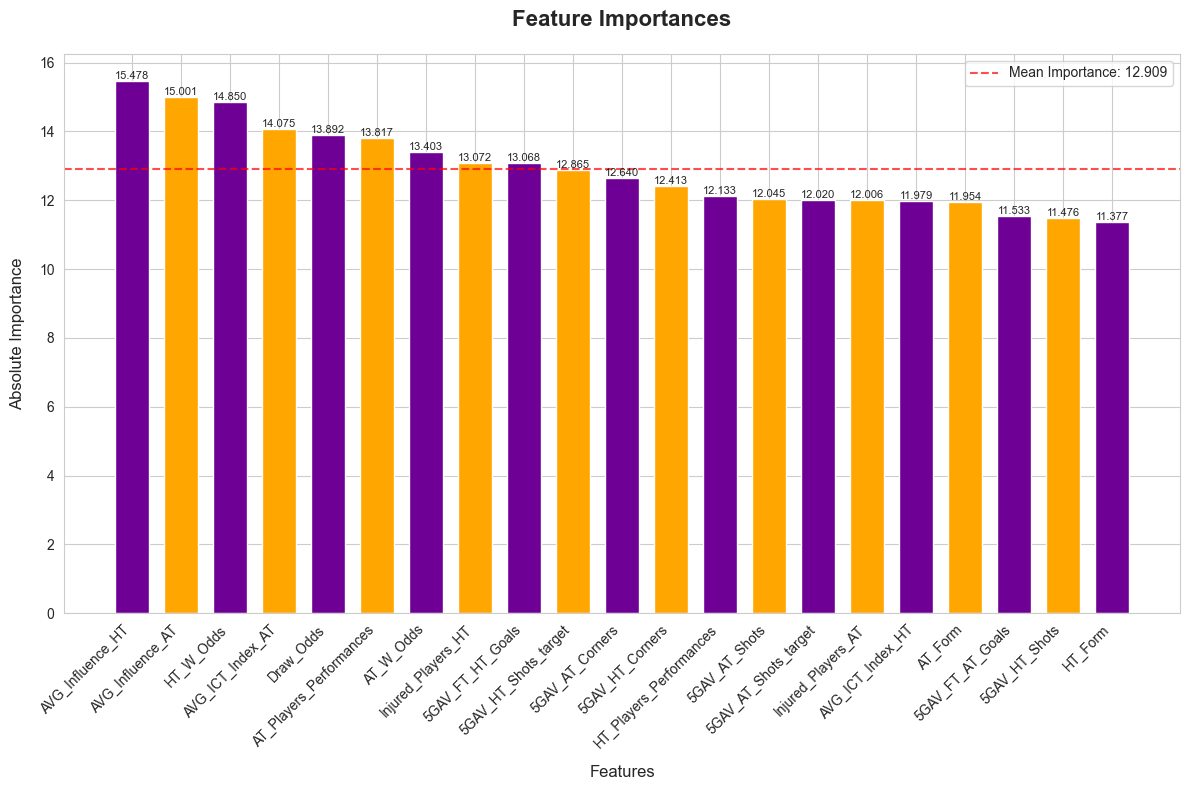

Top 10 most important features:
                    Feature  Importance
13         AVG_Influence_HT   15.477960
15         AVG_Influence_AT   15.000586
2                 HT_W_Odds   14.849733
16         AVG_ICT_Index_AT   14.075191
3                 Draw_Odds   13.892105
20  AT_Players_Performances   13.817204
4                 AT_W_Odds   13.402784
17       Injured_Players_HT   13.071778
5          5GAV_FT_HT_Goals   13.067943
9      5GAV_HT_Shots_target   12.865080

Final test accuracy: 69.26%


In [294]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

importances = model.network[0].weight.data.cpu().numpy()
feature_names = predictive_features

importances = np.abs(importances).sum(axis=0)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values('Importance', ascending=False)

total_importance = importance_df['Importance'].sum()

plt.figure(figsize=(12, 8))

colors = ["#6E0096", "#FFA600"] * (len(importance_df) // 2 + 1) 
bars = plt.bar(
    range(len(importance_df)), 
    importance_df['Importance'],
    color=colors[:len(importance_df)], 
    align="center",
    width=0.7
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2., 
        height + 0.001, 
        f'{height:.3f}', 
        ha='center', va='bottom', 
        fontsize=8, rotation=0
    )

mean_importance = importance_df['Importance'].mean()
plt.axhline(y=mean_importance, color='red', linestyle='--', alpha=0.7, 
           label=f'Mean Importance: {mean_importance:.3f}')

plt.title("Feature Importances", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Features", fontsize=12, labelpad=10)
plt.ylabel("Absolute Importance", fontsize=12, labelpad=10)

plt.xticks(
    range(len(importance_df)), 
    importance_df['Feature'], 
    rotation=45, 
    ha='right', 
    fontsize=10
)

plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend(loc='upper right')

plt.tight_layout()


plt.show()

print("Top 10 most important features:")
print(importance_df.head(10))

print(f"\nFinal test accuracy: {results['test_accuracy']:.2f}%")

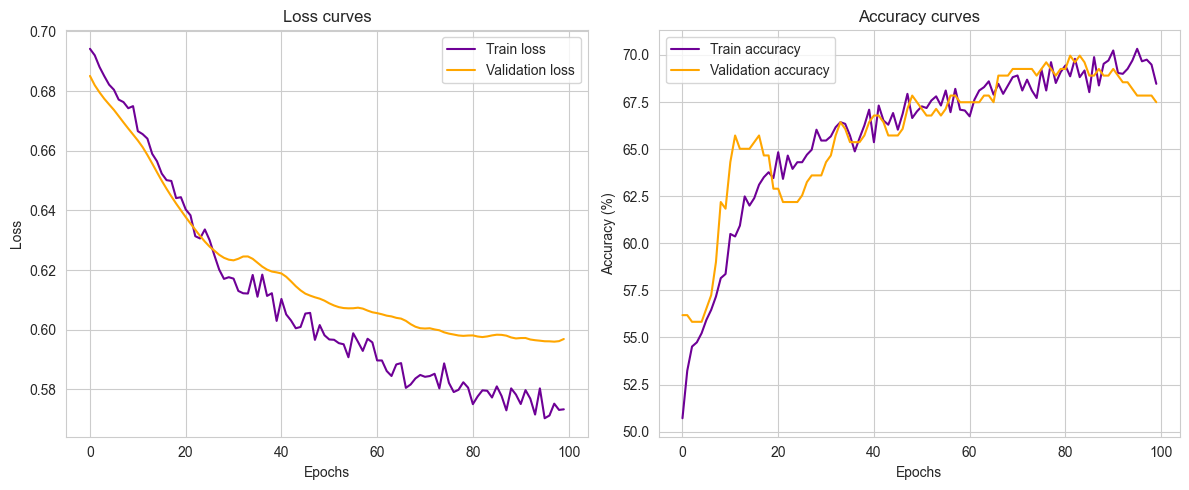

In [295]:
train_losses = results['train_losses']
val_losses = results['val_losses']
train_accuracies = results['train_accuracies']
val_accuracies = results['val_accuracies']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train loss", color="#6E0096")
plt.plot(val_losses, label="Validation loss", color="#FFA600")
plt.title("Loss curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train accuracy", color="#6E0096")
plt.plot(val_accuracies, label="Validation accuracy", color="#FFA600")
plt.title("Accuracy curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [296]:
# save the both models
torch.save(seq_model.state_dict(), "models/simple_model.pth")
torch.save(model.state_dict(), "models/improved_model.pth")